# OCBA-m

Source. Chen et al. (2008) 

Efficient Simulation Budget Allocation for Selecting an Optimal Subset


https://pubsonline.informs.org/doi/pdf/10.1287/ijoc.1080.0268

In [14]:
import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Utility funcs

In [15]:
def load_system(file_name, system, reps, reps_available, delim=','):
    """
    Reads system data from a txt file (assumes comma delimited by default).  
    Assumes that each column represents a system.
    Returns a numpy array.  Each row is a system (single row); each col is a replication
    
    
    @file_name = name of file containing csv data
    @system = index of system in txt file.
    @reps = replications wanted
    @reps_available = total number of replications that has been simulated.
    @delim = delimiter of file.  Default = ',' for CSV.  

    """
    
    return np.genfromtxt(file_name, delimiter=delim, usecols = system, skip_footer = (reps_available - reps))

In [16]:
def simulate(data, k, allocations):
    """
    Simulates the systems.  
    Each system is allocated a different budget of replications
    
    Returns list of numpy arrays
    
    @allocations = numpy array.  budget of replications for the k systems 
    """
    return [data[i][0:allocations[i]] for i in range(k)]
    

In [17]:
def get_ranks(array):
    """
    Returns a numpy array containing ranks of numbers within a input numpy array
    e.g. [3, 2, 1] returns [2, 1, 0]
    e.g. [3, 2, 1, 4] return [2, 1, 0, 3]
        
    @array - numpy array (only tested with 1d)
        
    """
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return ranks

In [18]:
def bootstrap(data, boots=1000):
    """
    Returns a numpy array containing the bootstrap resamples
    Useful for creating a large number of experimental datasets for testing R&S routines
    
    @data = numpy.array of systems to boostrap
    @boots = number of bootstrap (default = 1000)
    """

    experiments = boots
    designs = data.shape[0]
    samples = data.shape[1]

    datasets = np.zeros((experiments, designs, samples))
     
    for exp in range(experiments):
        
        for design in range(designs):

            for i in range(samples):

                datasets[exp][design][i] = data[design][round(np.random.uniform(0, samples)-1)]
      
    return datasets

In [19]:
@jit(nopython=True)
def crn_bootstrap(data, boots=1000):
    """
    Returns a numpy array containing the bootstrap resamples
    Useful for creating a large number of experimental datasets for testing R&S routines
    
    @data = numpy.array of systems to boostrap
    @boots = number of bootstrap (default = 1000)
    """

    experiments = boots
    designs = data.shape[0]
    samples = data.shape[1]
    
    datasets = np.zeros((experiments, designs, samples))
     
    for exp in range(experiments):
        
         for i in range(samples):

                row = data.T[np.random.choice(data.shape[0])]
                
                for design in range(designs):
                    datasets[exp][design][i] = row[design]  
      
    return datasets

# Walk through of how Ocba-m works

##  Input

**k** = total number of designs

**m** = no. of top designs to select

**T** = total budget (replications)

**n_0** = l number of replications  (>=5)

**delta** - additional budget to allocate between each simulation  

*where T - k.n_0 is a multiple of delta*


In [20]:
k = 10
m = 3
T = 2000
n_0 = 20
delta = 50

#specific to this implementation
ifile_name = 'data/EG1a.csv'
reps_available = 10000

### OCBA-m tutorial - single loop of the algorithm

The code below illustrates the implementation of OCBA-m with a single pass of the algorithm.

## Initialise

In [21]:
allocations = np.full(k, n_0, dtype=int)
allocations

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [13]:
data = load_systems(ifile_name)
systems = simulate(data, k, allocations)

NameError: name 'load_systems' is not defined

In [ ]:
#sample means, standard devs and standard errors
means = np.array([array.mean() for array in systems])

In [ ]:
stds = np.array([array.std() for array in systems])
ses = np.divide(stds, np.sqrt(allocations))

In [ ]:
means

In [10]:
ses

NameError: name 'ses' is not defined

In [15]:
#calculate paramater c and gammas

order = np.argsort(means)
s_ses = ses[order]
s_means = means[order]

order

array([0, 3, 1, 2, 4, 6, 5, 7, 9, 8])

In [16]:
s_means

array([ 0.23472479,  1.35755069,  2.47395206,  3.72000602,  6.20617173,
        6.23067599,  6.88773047,  7.49932228,  9.91920927, 10.66287029])

In [17]:
s_ses

array([1.32801684, 1.38482678, 1.11880913, 1.13609333, 1.2749415 ,
       1.10723931, 0.9565044 , 1.23771302, 1.07877839, 1.29598297])

In [18]:
c = ((s_ses[k-m+1] * s_means[k-m]) + (s_ses[k-m] * s_means[k-m+1]))/(s_ses[k-m]+s_ses[k-m+1])  
deltas = means - c

calculate c 

In [19]:
c

8.79228008028293

In [20]:
deltas

array([-8.55755529, -6.31832802, -5.07227406, -7.43472939, -2.58610835,
       -1.90454961, -2.56160409, -1.2929578 ,  1.87059021,  1.12692919])

## Allocate 

allocate additional budget **delta**

Procedure:

1. calculate ratio N_i/(se_i /gamma_i)^2

2. while additional budget delta is available

    2.1 rank

    2.2 add 1 to smallest 

    2.3 delta =- 1


In [21]:
values = np.divide(allocations, np.square(np.divide(ses, deltas)))
values

array([830.46676932, 637.85553686, 398.66434303, 576.46031991,
        82.28921438,  79.29405612, 107.04614289,  21.82522735,
        41.66666274,  21.82522735])

In [22]:

for i in range(delta):

    ranks = get_ranks(values)
    allocations[ranks.argmin()] += 1
    #recalculate values.
    values = np.divide(allocations, np.square(np.divide(ses, deltas)))

values

array([830.46676932, 637.85553686, 398.66434303, 576.46031991,
        82.28921438,  79.29405612, 107.04614289,  48.01550016,
        47.91666215,  46.92423879])

In [23]:
allocations

array([20, 20, 20, 20, 20, 20, 20, 44, 23, 43])

## Simulate

Simulate the next stage...

In [24]:
systems = simulate(data, k, allocations)
means2 = np.array([array.mean() for array in systems])
print(np.subtract(means2, means))


[ 0.          0.          0.          0.          0.          0.
  0.          0.05010138 -0.2985994  -0.03664751]


In [25]:
means = means2

and continue looping until budget is all used up...

### Full Implementation 

In [22]:
@jit(nopython=True)
def summary_statistics(systems, allocations):
    means = np.array([array.mean() for array in systems])
    stds = np.array([array.std() for array in systems])
    ses = np.divide(stds, np.sqrt(allocations))
    
    return means, ses

In [23]:
def top_m(means, m):
    """
    Returns the top m system designs
    """
    ranks = get_ranks(means)
    return np.argpartition(ranks, -m)[-m:]
     

In [24]:
@jit(nopython=True)
def parameter_c(means, ses, k, m):
    order = np.argsort(means)
    s_ses = ses[order]
    s_means = means[order]

    return((s_ses[k-m+1] * s_means[k-m]) + (s_ses[k-m] * s_means[k-m+1]))/(s_ses[k-m]+s_ses[k-m+1])  

In [25]:
def ocba_m(dataset, k, allocations, T, delta, m):
    
    while allocations.sum() < T:
        
        #simulate systems using new allocation of budget
        reps = simulate(dataset, k, allocations) 
        
        #calculate sample means and standard errors
        means, ses = summary_statistics(reps, allocations)
        
        #calculate parameter c and deltas
        c = parameter_c(means, ses, k, m)
        deltas = means - c
        
        #allocate
        for i in range(delta):
            values = np.divide(allocations, np.square(np.divide(ses, deltas)))
            ranks = get_ranks(values)
            allocations[ranks.argmin()] += 1
            
    return means, ses, allocations

In [26]:
def cs(selected_top_m, true_top_m):
    """
    Returns boolean value.  
    True = correct selection of top m
    False = incorrect selection (one or more of selected top m is incorrect)
    
    Keyword arguments:
    selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return np.array_equal(np.sort(selected_top_m), true_top_m)

In [27]:
def oc(true_means, selected_top_m, true_top_m):
    """
    Return the opportunity cost of the selection
    Method penalised particular bad solutions more than mildly bad
    
    @true_means - numpy.array of true means
    @selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    @true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return (true_means[selected_top_m] - true_means[true_top_m]).sum()

In [28]:
def p_cs(correct_selections):
    """
    Returns the probability of correct selection P{cs}
    Keyword arguments:
    
    correct_selections - list indicating if a given budget found the top m e.g. [False, True, True]
    """
    return np.array(correct_selections).sum() / len(correct_selections)

In [29]:
def p_cs2(correct_selections):
    """
    Returns the probability of correct selection P{cs}
    
    @correct_selections - numpy.array of budget versus exp. Contains True or False indicating correct selection.
    
    """
    return np.mean(correct_selections, axis=1)

In [30]:
def e_oc(opportunity_costs):
    """
    Return the expected opportunity cost E{oc}
    
    @opportunity costs - arrange of opportunity cost per budget
    """
    return np.array(opportunity_costs).mean()

In [31]:
def e_oc2(opportunity_costs):
    """
    Return the expected opportunity cost E{oc}
    
    @opportunity costs - arrange of opportunity cost per budget
    """
    return np.mean(opportunity_costs, axis=0)

# Numerical test - single experiment

### Create Experimental Data#

#### Use the following code to create independent samples

In [32]:
def experiments_independent_samples(ifile_name, boots=1000):
    data = np.genfromtxt(ifile_name, delimiter=",", skip_footer=0).transpose()
    experiments = bootstrap(data, boots=boots)
    return experiments

#### Use the following code to create CRN data sets

In [33]:
def experiments_dependent_samples(ifile_name, boots=1000):
    data = np.genfromtxt(ifile_name, delimiter=",", skip_footer=0).transpose()
    experiments = crn_bootstrap(data, boots=boots)
    return experiments

Use the `numerical_experiment()` function to run experiments of OBCA-m across multiple experimental datasets and budgets.

For example, you may have 100 datasets to test across budgets of 1000, 2000, 3000 and 4000 replications.

In [34]:
def numerical_experiment(experiments, budgets, delta, true_top_m, n_0):
    """
    Conduct a user set number of numerical experiments on the algorithm
    for different computational budgets
    
    Returns:
    1. numpy.array containing P{cs} for each budget
    2. numpy.array containing E{oc} for each budget
    
    Keyword arguments:
    experiments -- numpy.array[experiments][designs][replication]
    budgets -- python.list containing budgets
    delta - maximum amount of budget to allocate per run. 
    true_top_m -- top m (i.e. the systems that should be returned)
    n_0 -- initial number of replications per system
    
    """
    n_experiments = experiments.shape[0]
    k = experiments.shape[1]
    m = true_top_m.shape[0]
    
    #top_m_list = []
    #allocation_list = []
    #means_list = []
    
    correct_selections = np.zeros((n_experiments, len(budgets)))
    opportunity_costs = np.zeros((n_experiments, len(budgets)))

    for exp in range(n_experiments):

        for t in range(len(budgets)):

            allocations = np.full(k, n_0, dtype=int)
                        
            means, ses, allocations = ocba_m(experiments[exp], k, allocations, budgets[t], delta, m)
            selected_top_m = top_m(means, m)
            
            #diagnostic code - can be removed when fixed.
            #means_list.append(means)
            #allocation_list.append(allocations)
            #top_m_list.append(selected_top_m)
            correct_selections[exp][t] = cs(selected_top_m, true_top_m)
            #opportunity_costs[exp][t] = oc(true_means, selected_top_m, true_top_m)

    #can reduce number of returns when bug found
    return correct_selections

# Experiments for CRN data

In [ ]:
def get_budgets(max_t, min_t, increment_t):
    #incremental budgets 200, 400, .... T
    budgets = [i for i in range(min_t, max_t + increment_t, increment_t)]
    return budgets


In [46]:
def experiment_1():
    T = 2000
    increment_t = 100
    min_budget = 300
    n_0 = 20
    delta = 50

    #specific to this implementation
    ifile_name = 'data/EG1a_CRN.csv'
    reps_available = 10000

    #info for correct selection
    true_top_m = np.array([7, 8, 9])
    true_means = np.arange(1, 11)

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #generate experimental dataset
    experiments = experiments_dependent_samples(ifile_name, boots=10000)
    
    #run numerical experiment
    css = numerical_experiment(experiments, budgets, delta, true_top_m, n_0)
    
    return css

In [47]:
css = experiment_1()

In [48]:
df = pd.DataFrame(css)
df.to_clipboard()

In [76]:
#df = pd.DataFrame(css)
#df["select"] = top_m_list
#df["allocations"] = allocation_list
#df["means_list"] = np.around(means_list, decimals=4).tolist()
#df.head()

In [77]:
#print("top m: {0}".format(df[0:1]["select"].tolist()))
#print("Means selected: {0}".format(df[0:1]["means_list"].tolist()))
#print("Allocations: {0}".format(df[0:1]["allocations"].tolist()))

[]

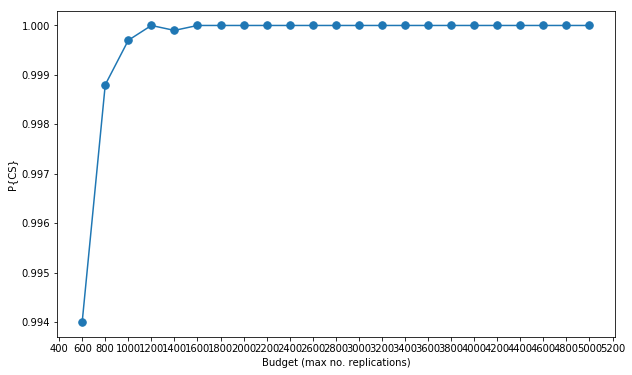

In [42]:
budgets = get_budgets(3000, 300, 100)
fig = plt.figure(figsize=(10,6))
ax = pd.DataFrame(css, columns=budgets).mean(axis=0).plot(style='.-', ms=15)
ax.set_ylabel("P{CS}")
ax.set_xlabel("Budget (max no. replications)")
ax.set_xticks(ticks = [i for i in range(200, 8000, 200)])

ax.plot()

[]

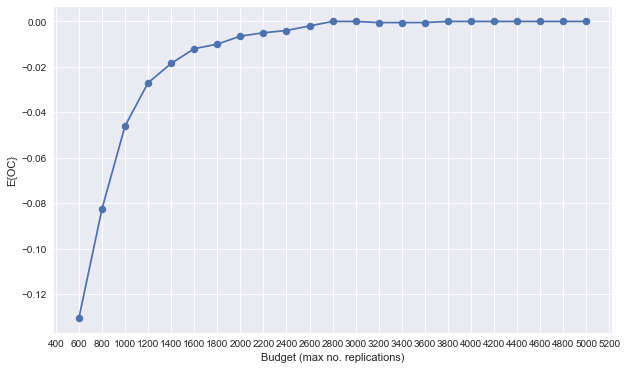

In [108]:
fig = plt.figure(figsize=(10,6))
ax = pd.DataFrame(ocs, columns=budgets).mean(axis=0).plot(style='.-', ms=15)
ax.set_ylabel("E{OC}")
ax.set_xlabel("Budget (max no. replications)")
ax.set_xticks(ticks = [i for i in range(200, 8000, 200)])

ax.plot()